In [2]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import skimage
from skimage.transform import resize
import cv2
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dropout
from tensorflow.keras.layers import Activation, Dense
import pandas as pd
import matplotlib.pyplot as plt # untuk menampilkan gambar
import seaborn as sns # untuk menampilkan diagram batang
from tensorflow import keras

print(tf.__version__)

2.6.0


----------------------------------데이터 로드----------------------------------

In [9]:
import pathlib

PATH = "C:\\Users\\HP\\Desktop\\Project\\asl"
file_path = pathlib.Path(PATH)
train_dir = os.path.join(file_path, '.\\train\\train')

BATCH_SIZE = 64
IMG_SIZE = (64, 64)

#train data set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

#valid data set
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

class_names = train_ds.class_names
class_name = len(class_names)
print(class_names)

Found 87000 files belonging to 29 classes.
Using 69600 files for training.
Found 87000 files belonging to 29 classes.
Using 17400 files for validation.
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


-------------------------VGG16-------------------------

In [12]:
img_shape = (64,64, 3)

VGG16_MODEL = tf.keras.applications.VGG16(input_shape = img_shape,
                                         include_top = False,
                                         weights = 'imagenet')
VGG16_MODEL.trainable=False

# flatten이 없음 ( globalaveragepooling으로 대체 ) #  ==> 가중치가 필요없음
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()   

# FFNN의 가중치는 학습됨
prediction_layer = tf.keras.layers.Dense(class_name, activation ='softmax')

# model : vgg16이 갖고있는 가중치 + FFNN 가중치로 학습
model_VGG16 = tf.keras.Sequential([
    VGG16_MODEL,
    global_average_layer,
    prediction_layer
])

In [13]:
model_VGG16.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 29)                14877     
Total params: 14,729,565
Trainable params: 14,877
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# 학습이 언제 자동 중단 될지를 설정합니다.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=20)

#최적화 모델이 저장될 폴더와 모델의 이름을 정합니다.
modelpath="./data/model/model_VGG16.hdf5"

# 최적화 모델을 업데이트하고 저장합니다.
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=0, save_best_only=True)

# 모델 컴파일
model_VGG16.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics=['accuracy'])

# 참고: gpu사용
with tf.device('/device:GPU:0'):
    epochs=5
    history_VGG16 = model_VGG16.fit(train_ds, epochs=epochs,
                   validation_steps=2,validation_data=(val_ds),
                   verbose=1, callbacks=[early_stopping_callback,checkpointer])

Epoch 1/5


In [4]:
# melihat total jumlah label yang unik, ada 24 kelas
unique_val = np.array(labels)
np.unique(unique_val)

NameError: name 'labels' is not defined

<AxesSubplot:ylabel='count'>

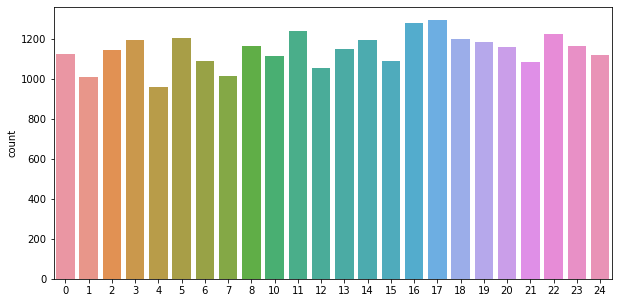

In [78]:

# melihat jumlah data tiap kelas kelas 
plt.figure(figsize = (10,5))
sns.countplot(x =labels)

In [79]:
# menghapus kolom label pada data training, karena kolom label sebelumnya sudah disimpan di variable labels
train.drop('label', axis = 1, inplace = True)

In [80]:
# menjadikan data train menjadi 1 array besar yang terdiri dari tiap data training
images = train.values
images = np.array([np.reshape(i, (28, 28)) for i in images])
images = np.array([i.flatten() for i in images])

In [82]:
# import data label yang biner. karena kelas yang ingin kita predisksi adalah integer value
from sklearn.preprocessing import LabelBinarizer
label_binrizer = LabelBinarizer()
labels = label_binrizer.fit_transform(labels)

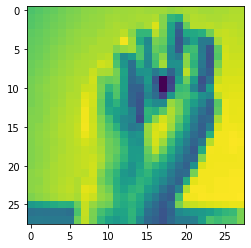

In [83]:
# contoh data gambar isyarat train data ke-1 
plt.imshow(images[4].reshape(28,28))

In [84]:
# mengubah data training 0.7 dan data testing 0.3
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.3, random_state = 101)

In [85]:
batch_size = 128
num_classes = 24
epochs = 50

In [86]:
# nilai piksel 256. kita bisa normalisasinya sehingga nilainya antara 0 sampai 1
x_train = x_train / 255
x_test = x_test / 255

In [87]:
# mengubah data train menjadi array 
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

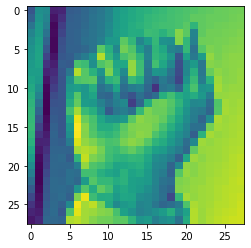

In [88]:
# contoh data yang sudah dinormalisasi 
plt.imshow(x_train[0].reshape(28,28))

------------------------------Layer 3개로 작업------------------------------

In [140]:
model = tf.keras.Sequential()

#First Convolution Layer
#kernel_size 3x3
model.add(Conv2D(64, kernel_size=(3,3), activation = 'relu', input_shape=(28, 28 ,1)))
model.add(MaxPooling2D(pool_size = (2, 2)))

#Second Convolution Layer
model.add(Conv2D(128, kernel_size = (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

#Third Convolution Layer
model.add(Conv2D(256, kernel_size = (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(BatchNormalization())
model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(1024, activation='sigmoid'))
#출력
model.add(Dense(num_classes, activation = 'softmax'))

model.compile(loss = keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

# eksekusi model dengan konfigurasi yang telah diatur
history = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs=epochs, batch_size=batch_size)

Epoch 1/15
151/151 [==============================] - 2s 8ms/step - loss: 1.0468 - accuracy: 0.7133 - val_loss: 1.9388 - val_accuracy: 0.5691
Epoch 2/15
151/151 [==============================] - 1s 7ms/step - loss: 0.0934 - accuracy: 0.9879 - val_loss: 0.5073 - val_accuracy: 0.9897
Epoch 3/15
151/151 [==============================] - 1s 6ms/step - loss: 0.0256 - accuracy: 0.9979 - val_loss: 0.0703 - val_accuracy: 0.9994
Epoch 4/15
151/151 [==============================] - 1s 6ms/step - loss: 0.0092 - accuracy: 0.9997 - val_loss: 0.0164 - val_accuracy: 0.9982
Epoch 5/15
151/151 [==============================] - 1s 7ms/step - loss: 0.0067 - accuracy: 0.9999 - val_loss: 0.0031 - val_accuracy: 1.0000
Epoch 6/15
151/151 [==============================] - 1s 7ms/step - loss: 0.0040 - accuracy: 0.9999 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 7/15
151/151 [==============================] - 1s 7ms/step - loss: 0.0042 - accuracy: 0.9997 - val_loss: 4.4522e-04 - val_accuracy: 1.0000
Ep

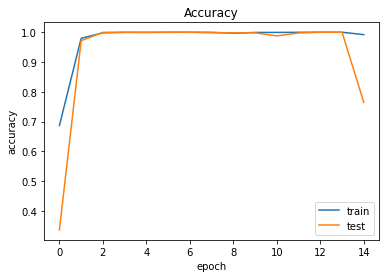

In [133]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','test'])
plt.show()

------------------------------Layer 5개로 작업------------------------------

In [105]:
model2 = tf.keras.Sequential()


model2.add(Conv2D(32, kernel_size=(3,3), activation = 'relu', input_shape=(28, 28 ,1) ))
model2.add(BatchNormalization())

model2.add(Conv2D(32, kernel_size=(3,3), activation = 'relu'))
model2.add(BatchNormalization())

model2.add(Conv2D(32, kernel_size=(5,5),strides=2, padding='same', activation = 'relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.4))

model2.add(Conv2D(64, kernel_size=(3,3), activation = 'relu'))
model2.add(BatchNormalization())
model2.add(Conv2D(64, kernel_size=(3,3), activation = 'relu'))
model2.add(BatchNormalization())
model2.add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.4))

model2.add(Conv2D(128, kernel_size = 4, activation='relu'))
model2.add(BatchNormalization())
model2.add(Flatten())
model2.add(Dropout(0.4))
model2.add(Dense(num_classes, activation='softmax'))

model2.compile(loss = keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

history2 = model2.fit(x_train, y_train, validation_data = (x_test, y_test), epochs=epochs, batch_size=batch_size)

Epoch 1/50
151/151 [==============================] - 3s 12ms/step - loss: 1.3837 - accuracy: 0.6084 - val_loss: 3.6226 - val_accuracy: 0.0694
Epoch 2/50
151/151 [==============================] - 1s 10ms/step - loss: 0.2327 - accuracy: 0.9384 - val_loss: 3.1598 - val_accuracy: 0.1867
Epoch 3/50
151/151 [==============================] - 1s 10ms/step - loss: 0.0839 - accuracy: 0.9829 - val_loss: 0.6098 - val_accuracy: 0.7937
Epoch 4/50
151/151 [==============================] - 1s 10ms/step - loss: 0.0423 - accuracy: 0.9922 - val_loss: 0.0081 - val_accuracy: 0.9998
Epoch 5/50
151/151 [==============================] - 1s 10ms/step - loss: 0.0269 - accuracy: 0.9951 - val_loss: 9.5308e-04 - val_accuracy: 1.0000
Epoch 6/50
151/151 [==============================] - 2s 10ms/step - loss: 0.0246 - accuracy: 0.9959 - val_loss: 8.5968e-04 - val_accuracy: 0.9999
Epoch 7/50
151/151 [==============================] - 2s 10ms/step - loss: 0.0130 - accuracy: 0.9982 - val_loss: 9.6331e-04 - val_accu

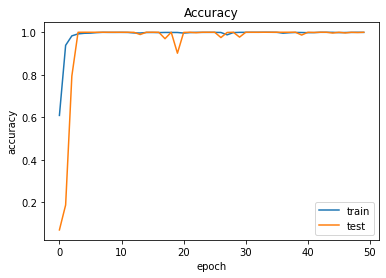

In [106]:
# melihat evaluasi tiap epoch activation function TANH
# jika dilihat di epoch ke 15 data sudah convergen
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title("Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','test'])
plt.show()

In [111]:
test = pd.read_csv('.\\data\\data\\sign_mnist_test.csv')
test_labels = test['label']
test.drop('label', axis = 1, inplace = True)

test_images = test.values
test_images = np.array([np.reshape(i, (28, 28)) for i in test_images])
test_images = np.array([i.flatten() for i in test_images])

test_labels = label_binrizer.fit_transform(test_labels)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

In [117]:
# prediksi data testing
y_pred_3L = model[0].predict(test_images)
y_pred_5L = model2.predict(test_images)

In [118]:
from sklearn.metrics import accuracy_score
# 모델 1, 레이어3개 의 정확도
accuracy_score(test_labels, y_pred_relu.round())

0.8131622978248745

In [119]:
# 모델 2 레이어 5개의 정확도
accuracy_score(test_labels, y_pred_tanh.round())

0.9085331846068042

------------------------------MNIST Dataset  끗------------------------------------

------------------------------ASL Dataset  시작------------------------------------

위 모델에서 input이 안맞아서 다시 만들었습니다! 하단에 간단하게 만들었습니다.

In [22]:
import pathlib

PATH = "C:\\Users\\HP\\Desktop\\Project\\asl"
file_path = pathlib.Path(PATH)

train_dir = os.path.join(file_path, '.\\train\\train')


BATCH_SIZE = 64
IMG_SIZE = (64, 64)

#train data set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

#valid data set
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

class_names = train_ds.class_names
print(class_names)

Found 87000 files belonging to 29 classes.
Using 69600 files for training.
Found 87000 files belonging to 29 classes.
Using 17400 files for validation.
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [23]:
#data autotune
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [24]:
# 3계층 레이어로 알파벳 훈련

model = tf.keras.Sequential()

model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu', input_shape = (64,64, 3)))
model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2), strides = 2, padding = 'same'))

model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2), strides = 2, padding = 'same'))

model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2), strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dense(len(class_names), activation = 'softmax')) # 2개의 출력을 가지는 신경망

model.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics = ['acc'])


from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=20)

modelpath="./data/model/model_asl_3.hdf5"

checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=0, save_best_only=True)

model.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics=['accuracy'])

with tf.device('/device:GPU:0'):

    epochs=15
    history = model.fit(train_ds, epochs=epochs,
                   validation_steps=2,validation_data=(val_ds),
                   verbose=1, callbacks=[early_stopping_callback,checkpointer])

Epoch 1/15
1088/1088 [==============================] - 87s 79ms/step - loss: 0.7865 - accuracy: 0.7765 - val_loss: 0.0453 - val_accuracy: 0.9766
Epoch 2/15
1088/1088 [==============================] - 86s 79ms/step - loss: 0.0662 - accuracy: 0.9790 - val_loss: 0.0797 - val_accuracy: 0.9844
Epoch 3/15
1088/1088 [==============================] - 85s 78ms/step - loss: 0.0413 - accuracy: 0.9872 - val_loss: 0.0082 - val_accuracy: 1.0000
Epoch 4/15
1088/1088 [==============================] - 84s 77ms/step - loss: 0.0351 - accuracy: 0.9897 - val_loss: 0.0139 - val_accuracy: 0.9922
Epoch 5/15
1088/1088 [==============================] - 85s 78ms/step - loss: 0.0295 - accuracy: 0.9909 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 6/15
1088/1088 [==============================] - 85s 78ms/step - loss: 0.0306 - accuracy: 0.9911 - val_loss: 0.0904 - val_accuracy: 0.9844
Epoch 7/15
1088/1088 [==============================] - 85s 77ms/step - loss: 0.0250 - accuracy: 0.9928 - val_loss: 0.0700 -

<Figure size 864x288 with 0 Axes>

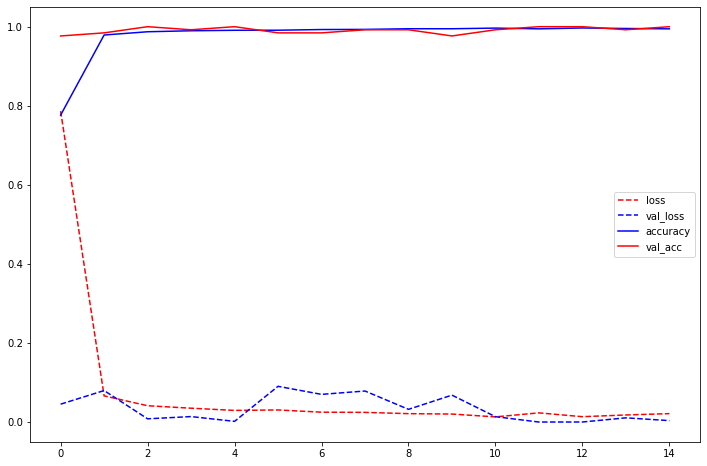

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.figure(figsize=(12,8))
plt.plot(history.history['loss'],'--',c='red')
plt.plot(history.history['val_loss'],'--',c='blue')
plt.plot(history.history['accuracy'],c='blue')
plt.plot(history.history['val_accuracy'],c='red')
plt.legend(['loss','val_loss', 'accuracy','val_acc'])
plt.show()

In [28]:
# 5계층으로 훈련

model5 = tf.keras.Sequential()
model5.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', input_shape = (64, 64, 3)))
model5.add(BatchNormalization())
model5.add(Activation('relu'))

model5.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same'))
model5.add(BatchNormalization())
model5.add(Activation('relu'))
model5.add(MaxPooling2D(pool_size = (2, 2), strides = 2, padding = 'same'))

model5.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same'))
model5.add(BatchNormalization())
model5.add(Activation('relu'))

model5.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same'))
model5.add(BatchNormalization())
model5.add(Activation('relu'))
model5.add(MaxPooling2D(pool_size = (2, 2), strides = 2, padding = 'same'))

model5.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same'))
model5.add(BatchNormalization())
model5.add(Activation('relu'))

model5.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same'))
model5.add(BatchNormalization())
model5.add(Activation('relu'))
model5.add(MaxPooling2D(pool_size = (2, 2), strides = 2, padding = 'same'))

model5.add(Flatten())
model5.add(Dense(256))
model5.add(BatchNormalization())
model5.add(Activation('relu'))
model5.add(Dense(len(class_names), activation = 'softmax'))

model5.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics = ['acc'])

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=20)

modelpath="./data/model/model_asl_5.hdf5"

checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=0, save_best_only=True)

model5.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics=['accuracy'])

with tf.device('/device:GPU:0'):

    epochs=15
    history5 = model5.fit(train_ds, epochs=epochs,
                   validation_steps=2,validation_data=(val_ds),
                   verbose=1, callbacks=[early_stopping_callback,checkpointer])

   

Epoch 1/15
1088/1088 [==============================] - 139s 125ms/step - loss: 0.2749 - accuracy: 0.9278 - val_loss: 0.3871 - val_accuracy: 0.9062
Epoch 2/15
1088/1088 [==============================] - 136s 124ms/step - loss: 0.0214 - accuracy: 0.9949 - val_loss: 0.1618 - val_accuracy: 0.9453
Epoch 3/15
1088/1088 [==============================] - 907s 834ms/step - loss: 0.0121 - accuracy: 0.9969 - val_loss: 1.2627 - val_accuracy: 0.6953
Epoch 4/15
1088/1088 [==============================] - 132s 121ms/step - loss: 0.0176 - accuracy: 0.9950 - val_loss: 0.1789 - val_accuracy: 0.9297
Epoch 5/15
1088/1088 [==============================] - 140s 128ms/step - loss: 0.0080 - accuracy: 0.9980 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 6/15
1088/1088 [==============================] - 142s 130ms/step - loss: 2.3992e-04 - accuracy: 1.0000 - val_loss: 9.5018e-05 - val_accuracy: 1.0000
Epoch 7/15
1088/1088 [==============================] - 144s 132ms/step - loss: 0.0167 - accuracy: 0.995

<Figure size 864x288 with 0 Axes>

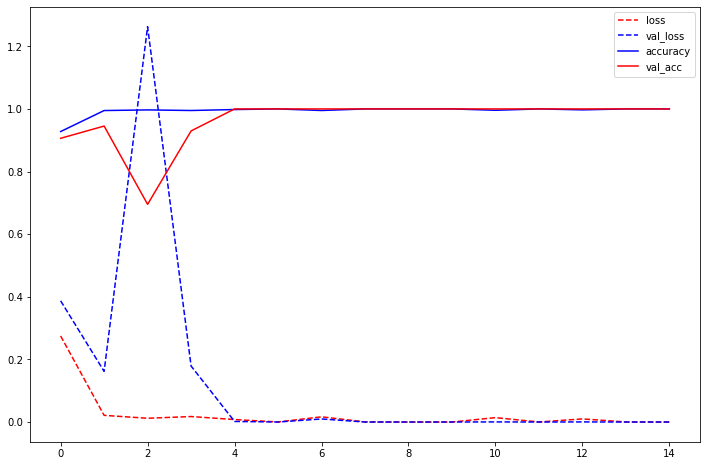

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.figure(figsize=(12,8))
plt.plot(history5.history['loss'],'--',c='red')
plt.plot(history5.history['val_loss'],'--',c='blue')
plt.plot(history5.history['accuracy'],c='blue')
plt.plot(history5.history['val_accuracy'],c='red')
plt.legend(['loss','val_loss', 'accuracy','val_acc'])
plt.show()

값이 하나 튀는건 아무래도, 논문에서 본것 처럼 혼동이 되는 알파벳 2개가 있어서 그런것 같습니다!

#### -----------------------------------VGG16으로 작업--------------------------------

In [30]:
img_shape = (64,64, 3)

# include_top = False인 경우 input_shape = img_size 지정 필요
VGG16_MODEL = tf.keras.applications.VGG16(input_shape = img_shape,
                                         include_top = False,
                                         weights = 'imagenet')

VGG16_MODEL.trainable=False     # VGG16모델 가중치는 변하지 않음.

# flatten이 없음 ( globalaveragepooling으로 대체 ) #  ==> 가중치가 필요없음
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()   

# FFNN의 가중치는 학습됨
prediction_layer = tf.keras.layers.Dense(len(class_names), activation ='softmax')

# model : vgg16이 갖고있는 가중치 + FFNN 가중치로 학습
model_VGG16_adam = tf.keras.Sequential([
    VGG16_MODEL,
    global_average_layer,
    prediction_layer
])

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# 학습이 언제 자동 중단 될지를 설정합니다.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=20)

#최적화 모델이 저장될 폴더와 모델의 이름을 정합니다.
modelpath="./data/model/model_VGG16_adam.hdf5"

# 최적화 모델을 업데이트하고 저장합니다.
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=0, save_best_only=True)

model_VGG16_adam.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics=['accuracy'])

# 참고: gpu사용
with tf.device('/device:GPU:0'):

    epochs=15
    history_VGG16_adam = model_VGG16_adam.fit(train_ds, epochs=epochs,
                   validation_steps=2,validation_data=(val_ds),
                   verbose=1, callbacks=[early_stopping_callback,checkpointer])

Epoch 1/15
1088/1088 [==============================] - 26s 22ms/step - loss: 1.5596 - accuracy: 0.7622 - val_loss: 0.2001 - val_accuracy: 0.9297
Epoch 2/15
1088/1088 [==============================] - 23s 21ms/step - loss: 0.1377 - accuracy: 0.9554 - val_loss: 0.0362 - val_accuracy: 0.9844
Epoch 3/15
1088/1088 [==============================] - 23s 21ms/step - loss: 0.0742 - accuracy: 0.9756 - val_loss: 0.1083 - val_accuracy: 0.9609
Epoch 4/15
1088/1088 [==============================] - 23s 21ms/step - loss: 0.0563 - accuracy: 0.9817 - val_loss: 0.0533 - val_accuracy: 0.9766
Epoch 5/15
1088/1088 [==============================] - 23s 21ms/step - loss: 0.0513 - accuracy: 0.9830 - val_loss: 0.0247 - val_accuracy: 0.9922
Epoch 6/15
1088/1088 [==============================] - 23s 21ms/step - loss: 0.0381 - accuracy: 0.9873 - val_loss: 0.0204 - val_accuracy: 0.9922
Epoch 7/15
1088/1088 [==============================] - 23s 21ms/step - loss: 0.0360 - accuracy: 0.9883 - val_loss: 0.0086 -

<Figure size 864x288 with 0 Axes>

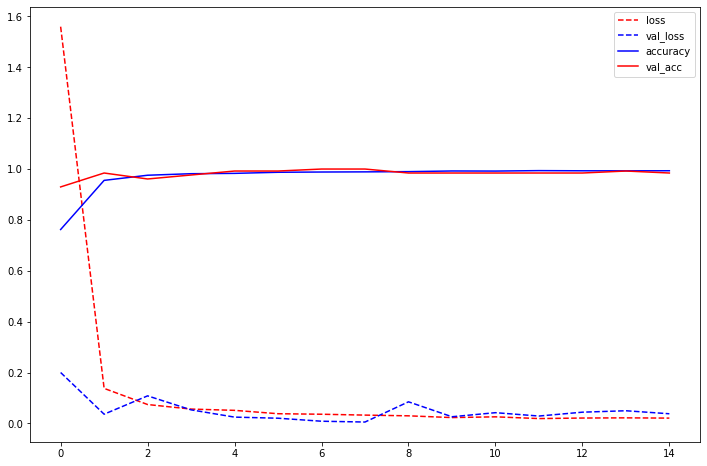

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.figure(figsize=(12,8))
plt.plot(history_VGG16_adam.history['loss'],'--',c='red')
plt.plot(history_VGG16_adam.history['val_loss'],'--',c='blue')
plt.plot(history_VGG16_adam.history['accuracy'],c='blue')
plt.plot(history_VGG16_adam.history['val_accuracy'],c='red')
plt.legend(['loss','val_loss', 'accuracy','val_acc'])
plt.show()

### 3레이어 모델(model), 5레이어 모델(model5), 
### VGG16(model_VGG16_adam)모델 평가

(64, 64, 3)
(1, 64, 64, 3)
(model_1)  A , 8.85 percent confidence. 
 (model_3)  A, 8.85 percent confidence. 
 (model_v)  S , 8.22 percent confidence.


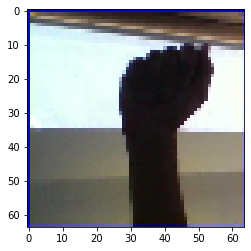

In [39]:
import keras
import glob

#테스트할 이미지 불러오기
tmp = glob.glob('.\\asl\\test\\test\\*.jpg')
img = keras.preprocessing.image.load_img(tmp[0], target_size=(64,64))
plt.imshow(img)


img_array = keras.preprocessing.image.img_to_array(img)
print(np.shape(img_array))

img_array = tf.expand_dims(img_array, 0) # Create a batch
print(np.shape(img_array))

predictions_1 = model.predict(img_array)
predictions_3 = model5.predict(img_array)
predictions_v = model_VGG16_adam.predict(img_array)

score_1 = tf.nn.softmax(predictions_1[0])
score_2 = tf.nn.softmax(predictions_3[0])
score_v = tf.nn.softmax(predictions_v[0])

print(
    "(model_1)  {} , {:.2f} percent confidence."
    .format(class_names[np.argmax(score_1)], 100 * np.max(score_1)),'\n',
    "(model_3)  {}, {:.2f} percent confidence."
    .format(class_names[np.argmax(score_2)], 100 * np.max(score_2)),'\n',
    "(model_v)  {} , {:.2f} percent confidence."
    .format(class_names[np.argmax(score_v)], 100 * np.max(score_v)))

#### ---------------------------예측값으로 혼돈행렬 그리기------------------------------

100%|████████████████████████████████████████████████████████████████████████████| 17400/17400 [08:45<00:00, 33.12it/s]


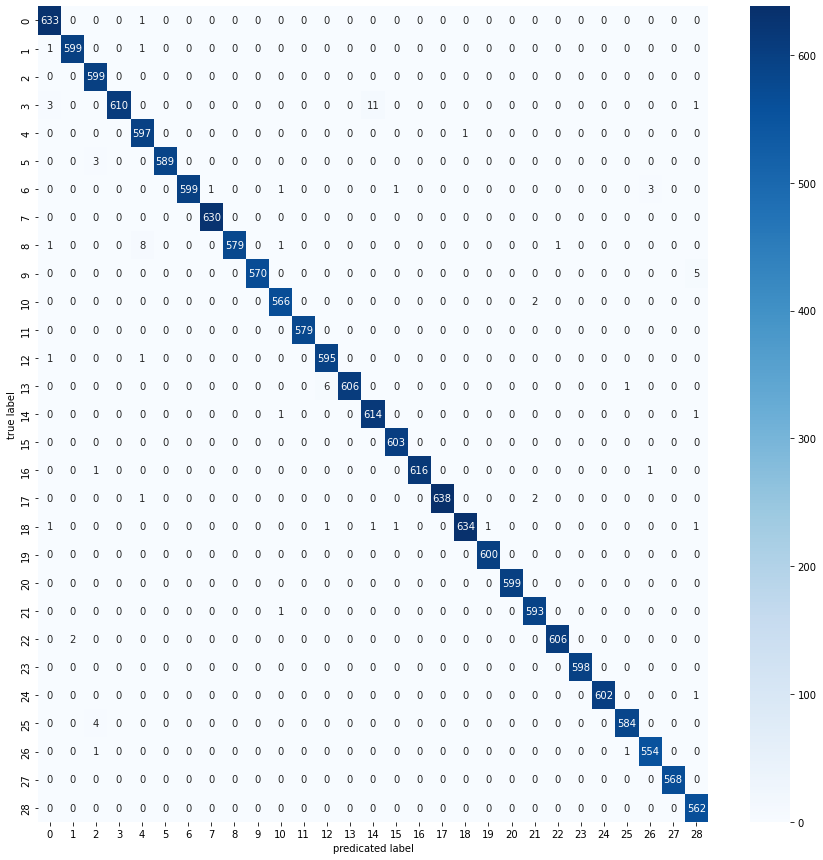

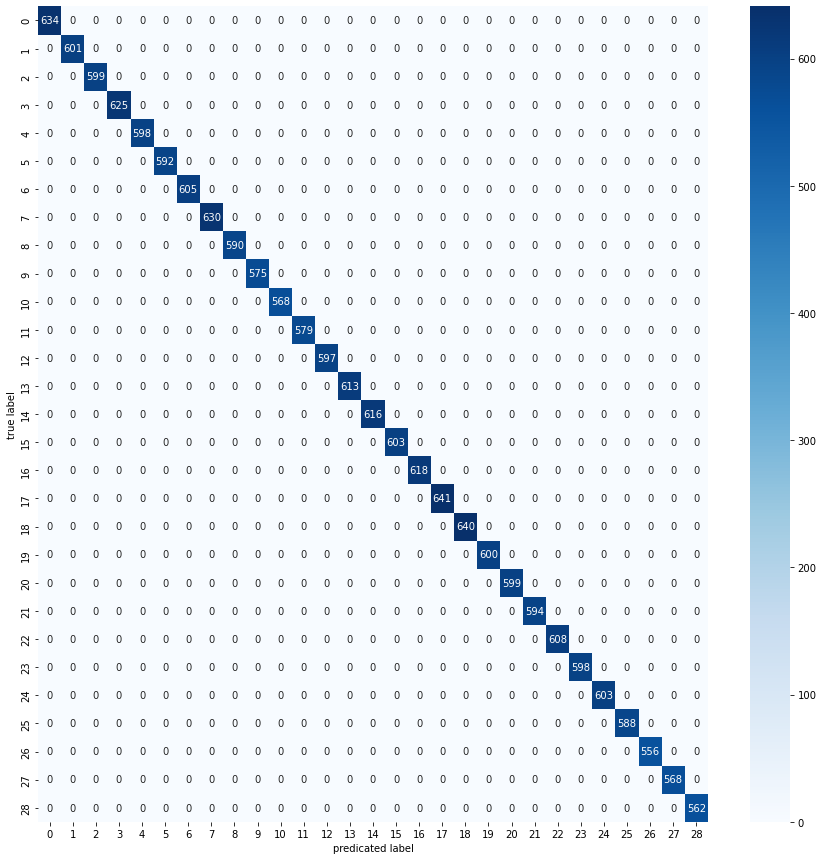

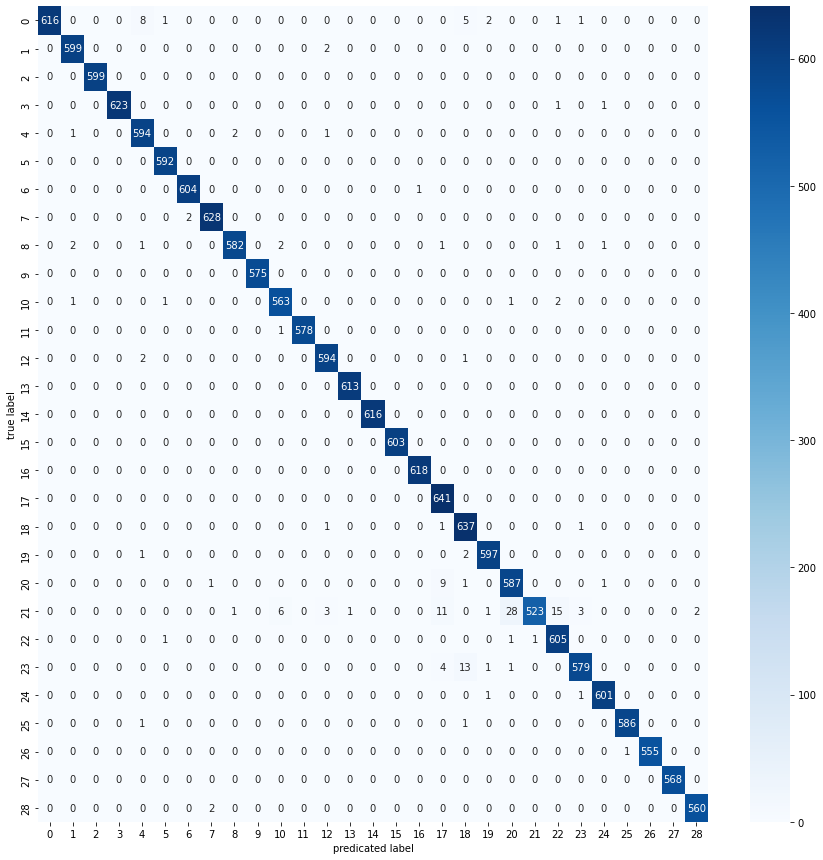

In [40]:
#테스트 데이터의 이미지전처리와 라벨링
test_all_label=[]; test_all_image=[]
for test_img, test_label in val_ds:
    test_all_label.extend(test_label.numpy())
    test_all_image.extend(test_img.numpy())
np.shape(test_all_label), np.shape(test_all_image)

model_VGG16_adam.predict(test_all_image[0].reshape(1,64,64,3),test_all_label[0])
model.predict(test_all_image[0].reshape(1,64,64,3),test_all_label[0])
model5.predict(test_all_image[0].reshape(1,64,64,3),test_all_label[0])

from tqdm import tqdm
result_3=[]
with tf.device('/device:GPU:0'):
    for img in tqdm(test_all_image):
        softmax=model.predict(img.reshape(1,64,64,3))
        result_3.append(np.argmax(softmax))
        
from tqdm import tqdm
result_v=[]
with tf.device('/device:GPU:0'):
    for img in tqdm(test_all_image):
        softmax=model_VGG16_adam.predict(img.reshape(1,64,64,3))
        result_v.append(np.argmax(softmax))
        
from tqdm import tqdm
result_5=[]
with tf.device('/device:GPU:0'):
    for img in tqdm(test_all_image):
        softmax=model5.predict(img.reshape(1,64,64,3))
        result_5.append(np.argmax(softmax))

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

#혼돈행렬만들기
plt.figure(figsize=(15,15))
cm=confusion_matrix(test_all_label, result_3)
sns.heatmap(cm, annot=True, fmt='d',cmap='Blues')
plt.xlabel('predicated label')
plt.ylabel('true label')

plt.figure(figsize=(15,15))
cm=confusion_matrix(test_all_label, result_5)
sns.heatmap(cm, annot=True, fmt='d',cmap='Blues')
plt.xlabel('predicated label')
plt.ylabel('true label')

plt.figure(figsize=(15,15))
cm=confusion_matrix(test_all_label, result_v)
sns.heatmap(cm, annot=True, fmt='d',cmap='Blues')
plt.xlabel('predicated label')
plt.ylabel('true label')
plt.show()

---------------------각 예측값으로 혼동행렬 그리기 끝------------------------------

숫자 파일을 가져와서 위 모델로 학습

In [41]:
import pathlib

PATH = "C:\\Users\\HP\\Desktop\\Project\\num"
file_path = pathlib.Path(PATH)

train_dir = os.path.join(file_path, '.\\train')

BATCH_SIZE = 64
IMG_SIZE = (64, 64)

#train data set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

#valid data set
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

num_names = train_ds.class_names
print(num_names)

Found 16500 files belonging to 11 classes.
Using 13200 files for training.
Found 16500 files belonging to 11 classes.
Using 3300 files for validation.
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'unknown']


모델 로드-------------------------------------------------------------------

In [ ]:
# from tensorflow.keras.models import load_model
# model_num_3 = load_model('.\\data\model\\model_3.hdf5')
# model_num_5 = load_model('.\\data\model\\model_5.hdf5')
# model_num_v = load_model('.\\data\model\\model_v.hdf5')

아웃풋 레이어-----------------------------------------------------

In [42]:
prediction_layer = tf.keras.layers.Dense(len(num_names), activation ='softmax')

model_num_3 = tf.keras.Sequential([
    model,
    prediction_layer]) 
model_num_5 = tf.keras.Sequential([
    model5,
    prediction_layer]) 
model_num_v = tf.keras.Sequential([
    model_VGG16_adam,
    prediction_layer]) 

In [43]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# 학습이 언제 자동 중단 될지를 설정합니다.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=20)

#최적화 모델이 저장될 폴더와 모델의 이름을 정합니다.
modelpath="./data/model/model_num_adam.hdf5"

# 최적화 모델을 업데이트하고 저장합니다.
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=0, save_best_only=True)

model_num_3.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics=['accuracy'])
model_num_5.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics=['accuracy'])
model_num_v.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics=['accuracy'])

# 참고: gpu사용
with tf.device('/device:GPU:0'):

    epochs=20
    history_num_3 = model_num_3.fit(train_ds, epochs=epochs,
                   validation_steps=2,validation_data=(val_ds),
                   verbose=1, callbacks=[early_stopping_callback,checkpointer])
    
    history_num_5 = model_num_5.fit(train_ds, epochs=epochs,
                   validation_steps=2,validation_data=(val_ds),
                   verbose=1, callbacks=[early_stopping_callback,checkpointer])
    
    history_num_v = model_num_v.fit(train_ds, epochs=epochs,
                   validation_steps=2,validation_data=(val_ds),
                   verbose=1, callbacks=[early_stopping_callback,checkpointer])

Epoch 1/20
207/207 [==============================] - 6s 26ms/step - loss: 2.2120 - accuracy: 0.3658 - val_loss: 2.0552 - val_accuracy: 0.5625
Epoch 2/20
207/207 [==============================] - 5s 24ms/step - loss: 1.9711 - accuracy: 0.5413 - val_loss: 1.7985 - val_accuracy: 0.5703
Epoch 3/20
207/207 [==============================] - 5s 25ms/step - loss: 1.8087 - accuracy: 0.5382 - val_loss: 1.8563 - val_accuracy: 0.4922
Epoch 4/20
207/207 [==============================] - 5s 25ms/step - loss: 1.7660 - accuracy: 0.4867 - val_loss: 1.7874 - val_accuracy: 0.4844
Epoch 5/20
207/207 [==============================] - 5s 25ms/step - loss: 1.6202 - accuracy: 0.5211 - val_loss: 1.4893 - val_accuracy: 0.5547
Epoch 6/20
207/207 [==============================] - 5s 25ms/step - loss: 1.5815 - accuracy: 0.5118 - val_loss: 1.8383 - val_accuracy: 0.4375
Epoch 7/20
207/207 [==============================] - 5s 25ms/step - loss: 1.5946 - accuracy: 0.4881 - val_loss: 1.6512 - val_accuracy: 0.4609

207/207 [==============================] - 5s 24ms/step - loss: 1.2330 - accuracy: 0.5346 - val_loss: 1.2071 - val_accuracy: 0.5469
Epoch 19/20
207/207 [==============================] - 5s 24ms/step - loss: 1.2058 - accuracy: 0.5423 - val_loss: 1.2046 - val_accuracy: 0.5156
Epoch 20/20
207/207 [==============================] - 5s 24ms/step - loss: 1.1790 - accuracy: 0.5530 - val_loss: 1.2512 - val_accuracy: 0.5312


## 모델 학습 후 시각화

<Figure size 864x288 with 0 Axes>

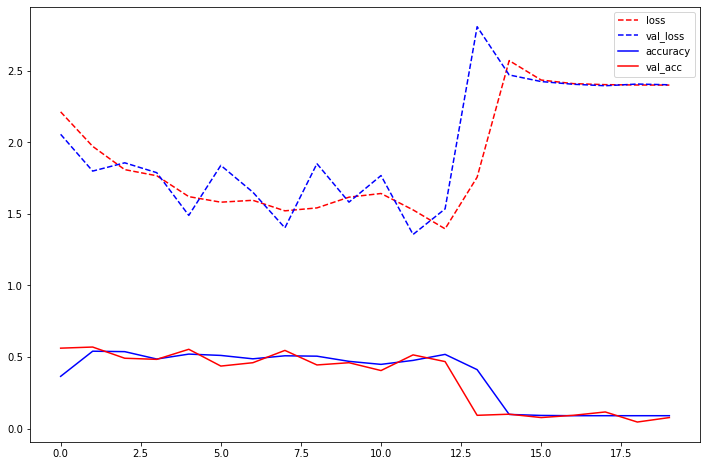

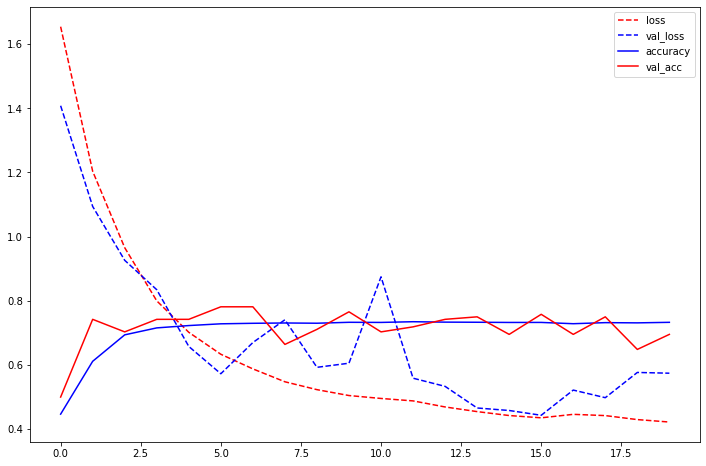

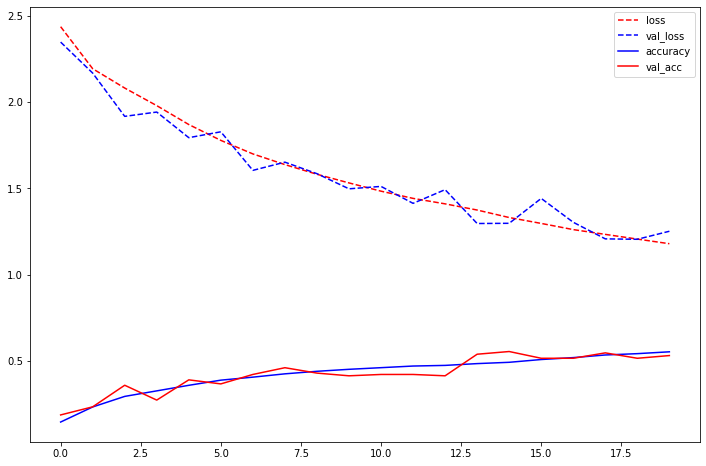

In [44]:
plt.figure(figsize=(12,4))

plt.figure(figsize=(12,8))
plt.plot(history_num_3.history['loss'],'--',c='red')
plt.plot(history_num_3.history['val_loss'],'--',c='blue')
plt.plot(history_num_3.history['accuracy'],c='blue')
plt.plot(history_num_3.history['val_accuracy'],c='red')
plt.legend(['loss','val_loss', 'accuracy','val_acc'])

plt.figure(figsize=(12,8))
plt.plot(history_num_5.history['loss'],'--',c='red')
plt.plot(history_num_5.history['val_loss'],'--',c='blue')
plt.plot(history_num_5.history['accuracy'],c='blue')
plt.plot(history_num_5.history['val_accuracy'],c='red')
plt.legend(['loss','val_loss', 'accuracy','val_acc'])

plt.figure(figsize=(12,8))
plt.plot(history_num_v.history['loss'],'--',c='red')
plt.plot(history_num_v.history['val_loss'],'--',c='blue')
plt.plot(history_num_v.history['accuracy'],c='blue')
plt.plot(history_num_v.history['val_accuracy'],c='red')
plt.legend(['loss','val_loss', 'accuracy','val_acc'])
plt.show()

In [46]:
model_num_3.evaluate(val_ds)

model_num_5.evaluate(val_ds)

model_num_v.evaluate(val_ds)

52/52 [==============================] - 2s 37ms/step - loss: 1.2662 - accuracy: 0.5412


[1.2662053108215332, 0.5412121415138245]

---------------------------------------- asl alphabat + number----------------------------------------------------------

In [48]:
import pathlib

PATH = "C:\\Users\\HP\\Desktop\\Project\\data"
file_path = pathlib.Path(PATH)

train_dir = os.path.join(file_path, '.\\data')

BATCH_SIZE = 64
IMG_SIZE = (64, 64)

#train data set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

#valid data set
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

class_names = train_ds.class_names
print(class_names)

Found 99000 files belonging to 38 classes.
Using 79200 files for training.
Found 99000 files belonging to 38 classes.
Using 19800 files for validation.
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'space']


In [49]:
#data autotune
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [52]:
model = tf.keras.Sequential()

model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu', input_shape = (64,64, 3)))
model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2), strides = 2, padding = 'same'))

model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2), strides = 2, padding = 'same'))

model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2), strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dense(len(class_names), activation = 'softmax')) # 2개의 출력을 가지는 신경망

model.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics = ['acc'])


from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=20)

modelpath="./data/model/model_asl_num_3.hdf5"

checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=0, save_best_only=True)

model.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics=['accuracy'])

with tf.device('/device:GPU:0'):

    epochs=15
    history = model.fit(train_ds, epochs=epochs,
                   validation_steps=2,validation_data=(val_ds),
                   verbose=1, callbacks=[early_stopping_callback,checkpointer])

Epoch 1/15
1238/1238 [==============================] - 33s 26ms/step - loss: 0.7654 - accuracy: 0.7879 - val_loss: 0.1020 - val_accuracy: 0.9609
Epoch 2/15
1238/1238 [==============================] - 27s 22ms/step - loss: 0.0944 - accuracy: 0.9700 - val_loss: 0.1683 - val_accuracy: 0.9531
Epoch 3/15
1238/1238 [==============================] - 27s 22ms/step - loss: 0.0631 - accuracy: 0.9797 - val_loss: 0.1211 - val_accuracy: 0.9844
Epoch 4/15
1238/1238 [==============================] - 28s 22ms/step - loss: 0.0488 - accuracy: 0.9848 - val_loss: 0.0259 - val_accuracy: 0.9922
Epoch 5/15
1238/1238 [==============================] - 28s 22ms/step - loss: 0.0399 - accuracy: 0.9882 - val_loss: 0.0833 - val_accuracy: 0.9688
Epoch 6/15
1238/1238 [==============================] - 28s 22ms/step - loss: 0.0396 - accuracy: 0.9885 - val_loss: 0.0833 - val_accuracy: 0.9766
Epoch 7/15
1238/1238 [==============================] - 28s 23ms/step - loss: 0.0313 - accuracy: 0.9907 - val_loss: 0.0144 -

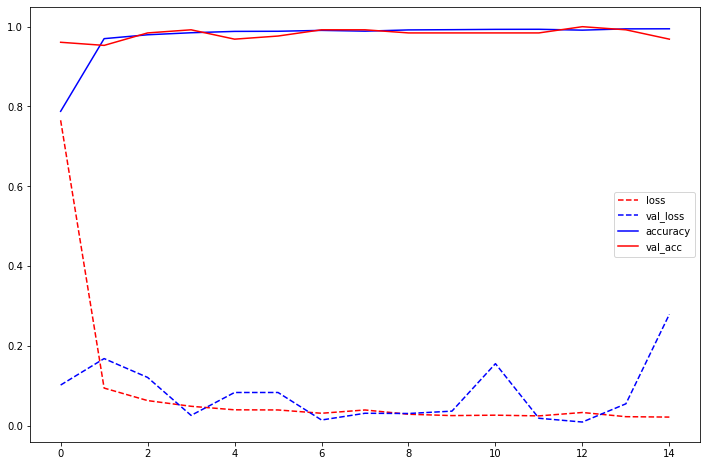

In [53]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'],'--',c='red')
plt.plot(history.history['val_loss'],'--',c='blue')
plt.plot(history.history['accuracy'],c='blue')
plt.plot(history.history['val_accuracy'],c='red')
plt.legend(['loss','val_loss', 'accuracy','val_acc'])

데이터를 늘리니 확실히 성능이 좋아집니다!

In [54]:
# 5계층으로 훈련

model5 = tf.keras.Sequential()
model5.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same', input_shape = (64, 64, 3)))
model5.add(BatchNormalization())
model5.add(Activation('relu'))

model5.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same'))
model5.add(BatchNormalization())
model5.add(Activation('relu'))
model5.add(MaxPooling2D(pool_size = (2, 2), strides = 2, padding = 'same'))

model5.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same'))
model5.add(BatchNormalization())
model5.add(Activation('relu'))

model5.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same'))
model5.add(BatchNormalization())
model5.add(Activation('relu'))
model5.add(MaxPooling2D(pool_size = (2, 2), strides = 2, padding = 'same'))

model5.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same'))
model5.add(BatchNormalization())
model5.add(Activation('relu'))

model5.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same'))
model5.add(BatchNormalization())
model5.add(Activation('relu'))
model5.add(MaxPooling2D(pool_size = (2, 2), strides = 2, padding = 'same'))

model5.add(Flatten())
model5.add(Dense(256))
model5.add(BatchNormalization())
model5.add(Activation('relu'))
model5.add(Dense(len(class_names), activation = 'softmax'))

model5.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics = ['acc'])

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=20)

modelpath="./data/model/model_asl_num_5.hdf5"

checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=0, save_best_only=True)

model5.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics=['accuracy'])

with tf.device('/device:GPU:0'):

    epochs=15
    history5 = model5.fit(train_ds, epochs=epochs,
                   validation_steps=2,validation_data=(val_ds),
                   verbose=1, callbacks=[early_stopping_callback,checkpointer])

   

Epoch 1/15
1238/1238 [==============================] - 35s 27ms/step - loss: 0.3499 - accuracy: 0.9035 - val_loss: 0.1057 - val_accuracy: 0.9688
Epoch 2/15
1238/1238 [==============================] - 34s 28ms/step - loss: 0.0355 - accuracy: 0.9906 - val_loss: 0.1743 - val_accuracy: 0.9375
Epoch 3/15
1238/1238 [==============================] - 34s 28ms/step - loss: 0.0246 - accuracy: 0.9936 - val_loss: 0.0207 - val_accuracy: 1.0000
Epoch 4/15
1238/1238 [==============================] - 35s 28ms/step - loss: 0.0201 - accuracy: 0.9946 - val_loss: 0.0754 - val_accuracy: 0.9688
Epoch 5/15
1238/1238 [==============================] - 35s 28ms/step - loss: 0.0162 - accuracy: 0.9954 - val_loss: 0.1257 - val_accuracy: 0.9531
Epoch 6/15
1238/1238 [==============================] - 35s 28ms/step - loss: 0.0116 - accuracy: 0.9968 - val_loss: 0.1034 - val_accuracy: 0.9766
Epoch 7/15
1238/1238 [==============================] - 35s 28ms/step - loss: 0.0079 - accuracy: 0.9978 - val_loss: 0.0377 -

데이터를 늘이니 작은 에포크에서도 loss값이 확실하게 점차 줄고  확실하게 맞추는 성능의 모델을 보여준다.
레이어가 2개 더 있어서 그런지 걸리는 시간이 3레이어는 평균 30초 이하, 5레이어 모델은 35초 이상으로 확인된다.

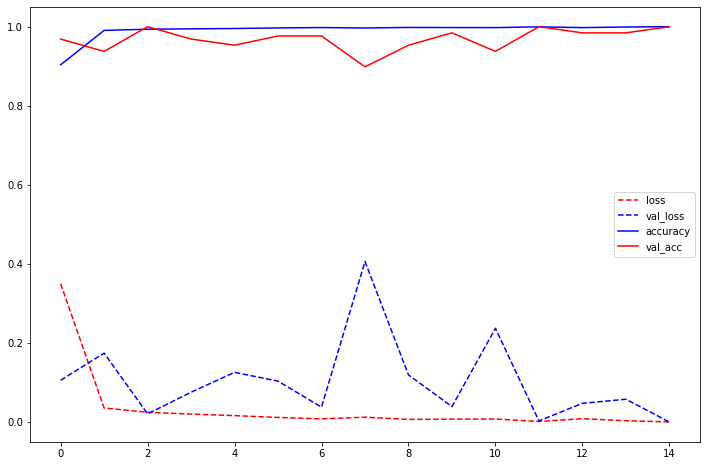

In [55]:
plt.figure(figsize=(12,8))
plt.plot(history5.history['loss'],'--',c='red')
plt.plot(history5.history['val_loss'],'--',c='blue')
plt.plot(history5.history['accuracy'],c='blue')
plt.plot(history5.history['val_accuracy'],c='red')
plt.legend(['loss','val_loss', 'accuracy','val_acc'])

In [58]:
img_shape = (64,64, 3)

# include_top = False인 경우 input_shape = img_size 지정 필요
VGG16_MODEL = tf.keras.applications.VGG16(input_shape = img_shape,
                                         include_top = False,
                                         weights = 'imagenet')

VGG16_MODEL.trainable=False     # VGG16모델 가중치는 변하지 않음.

# flatten이 없음 ( globalaveragepooling으로 대체 ) #  ==> 가중치가 필요없음
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()   

# FFNN의 가중치는 학습됨
prediction_layer = tf.keras.layers.Dense(len(class_names), activation ='softmax')

# model : vgg16이 갖고있는 가중치 + FFNN 가중치로 학습
model_VGG16_adam = tf.keras.Sequential([
    VGG16_MODEL,
    global_average_layer,
    prediction_layer
])

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# 학습이 언제 자동 중단 될지를 설정합니다.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=20)

#최적화 모델이 저장될 폴더와 모델의 이름을 정합니다.
modelpath="./data/model/model_VGG16_v.hdf5"

# 최적화 모델을 업데이트하고 저장합니다.
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=0, save_best_only=True)

model_VGG16_adam.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics=['accuracy'])

# 참고: gpu사용
with tf.device('/device:GPU:0'):

    epochs=15
    history_VGG16_adam = model_VGG16_adam.fit(train_ds, epochs=epochs,
                   validation_steps=2,validation_data=(val_ds),
                   verbose=1, callbacks=[early_stopping_callback,checkpointer])

Epoch 1/15
1238/1238 [==============================] - 26s 20ms/step - loss: 1.7358 - accuracy: 0.7400 - val_loss: 0.2607 - val_accuracy: 0.9297
Epoch 2/15
1238/1238 [==============================] - 26s 21ms/step - loss: 0.2466 - accuracy: 0.9332 - val_loss: 0.3192 - val_accuracy: 0.9375
Epoch 3/15
1238/1238 [==============================] - 26s 21ms/step - loss: 0.1612 - accuracy: 0.9548 - val_loss: 0.1730 - val_accuracy: 0.9766
Epoch 4/15
1238/1238 [==============================] - 26s 21ms/step - loss: 0.1375 - accuracy: 0.9603 - val_loss: 0.3470 - val_accuracy: 0.9453
Epoch 5/15
1238/1238 [==============================] - 26s 21ms/step - loss: 0.1138 - accuracy: 0.9671 - val_loss: 0.1426 - val_accuracy: 0.9688
Epoch 6/15
1238/1238 [==============================] - 26s 21ms/step - loss: 0.1037 - accuracy: 0.9701 - val_loss: 0.1259 - val_accuracy: 0.9844
Epoch 7/15
1238/1238 [==============================] - 26s 21ms/step - loss: 0.0963 - accuracy: 0.9720 - val_loss: 0.1269 -

학습에 걸리는 시간이 다른 모델들 보다 확실하게 빠르다. 3레이어 - 28~30, 5레이어 - 30초 중반, vgg모델 - 20초 중반,
vgg16가 레이어가 많은것 치고 굉장히 빠르게 진행 된다.

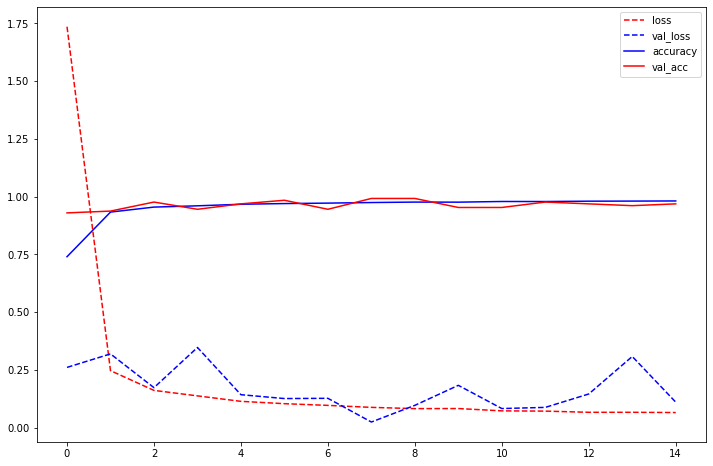

In [59]:
plt.figure(figsize=(12,8))
plt.plot(history_VGG16_adam.history['loss'],'--',c='red')
plt.plot(history_VGG16_adam.history['val_loss'],'--',c='blue')
plt.plot(history_VGG16_adam.history['accuracy'],c='blue')
plt.plot(history_VGG16_adam.history['val_accuracy'],c='red')
plt.legend(['loss','val_loss', 'accuracy','val_acc'])

In [193]:
model.trainable = False
base_model = model

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(len(class_names))

In [195]:

inputs = tf.keras.Input(shape=(64, 64, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [196]:
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
tf.math.truediv_11 (TFOpLamb (None, 64, 64, 3)         0         
_________________________________________________________________
tf.math.subtract_11 (TFOpLam (None, 64, 64, 3)         0         
_________________________________________________________________
sequential_55 (Sequential)   (None, 24)                9834648   
_________________________________________________________________
dropout_59 (Dropout)         (None, 24)                0         
_________________________________________________________________
dense_82 (Dense)             (None, 29)                725       
Total params: 9,835,373
Trainable params: 725
Non-trainable params: 9,834,648
_______________________________________________

In [197]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [198]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# 학습이 언제 자동 중단 될지를 설정합니다.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=20)

#최적화 모델이 저장될 폴더와 모델의 이름을 정합니다.
modelpath2="./data/model/model_asl.hdf5"

# 최적화 모델을 업데이트하고 저장합니다.
checkpointer = ModelCheckpoint(filepath=modelpath2, monitor='val_loss', verbose=0, save_best_only=True)

with tf.device('/device:GPU:0'):
    #모델을 실행합니다
    epochs=15
    hist_asl = model.fit(train_ds, epochs=epochs,
                       validation_steps=2,validation_data=(val_ds),
                       verbose=1, callbacks=[early_stopping_callback,checkpointer])

Epoch 1/15


ValueError: in user code:

    C:\Users\HP\miniconda3\envs\gpu2.6\lib\site-packages\keras\engine\training.py:853 train_function  *
        return step_function(self, iterator)
    C:\Users\HP\miniconda3\envs\gpu2.6\lib\site-packages\keras\engine\training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\HP\miniconda3\envs\gpu2.6\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\HP\miniconda3\envs\gpu2.6\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\HP\miniconda3\envs\gpu2.6\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\HP\miniconda3\envs\gpu2.6\lib\site-packages\keras\engine\training.py:835 run_step  **
        outputs = model.train_step(data)
    C:\Users\HP\miniconda3\envs\gpu2.6\lib\site-packages\keras\engine\training.py:789 train_step
        y, y_pred, sample_weight, regularization_losses=self.losses)
    C:\Users\HP\miniconda3\envs\gpu2.6\lib\site-packages\keras\engine\compile_utils.py:201 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    C:\Users\HP\miniconda3\envs\gpu2.6\lib\site-packages\keras\losses.py:141 __call__
        losses = call_fn(y_true, y_pred)
    C:\Users\HP\miniconda3\envs\gpu2.6\lib\site-packages\keras\losses.py:245 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    C:\Users\HP\miniconda3\envs\gpu2.6\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\HP\miniconda3\envs\gpu2.6\lib\site-packages\keras\losses.py:1809 binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    C:\Users\HP\miniconda3\envs\gpu2.6\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\HP\miniconda3\envs\gpu2.6\lib\site-packages\keras\backend.py:5000 binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)
    C:\Users\HP\miniconda3\envs\gpu2.6\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\HP\miniconda3\envs\gpu2.6\lib\site-packages\tensorflow\python\ops\nn_impl.py:246 sigmoid_cross_entropy_with_logits_v2
        logits=logits, labels=labels, name=name)
    C:\Users\HP\miniconda3\envs\gpu2.6\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\HP\miniconda3\envs\gpu2.6\lib\site-packages\tensorflow\python\ops\nn_impl.py:133 sigmoid_cross_entropy_with_logits
        (logits.get_shape(), labels.get_shape()))

    ValueError: logits and labels must have the same shape ((None, 29) vs (None, 1))


In [22]:
import pathlib

PATH = "C:\\Users\\HP\\Desktop\\Project\\asl"
file_path = pathlib.Path(PATH)

train_dir = os.path.join(file_path, '.\\train\\train')


BATCH_SIZE = 64
IMG_SIZE = (64, 64)

#train data set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

#valid data set
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

class_names = train_ds.class_names
print(class_names)

Found 87000 files belonging to 29 classes.
Using 69600 files for training.
Found 87000 files belonging to 29 classes.
Using 17400 files for validation.
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
